In [175]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import sklearn.preprocessing as prep
import scipy.stats

%matplotlib inline

In [2]:
with open("/Volumes/thesis-data/dtype_dict.json", "r") as d:
    dtypes = json.load(d)


In [3]:
main = pd.read_csv(
    "/Volumes/thesis-data/main.csv",
    dtype=dtypes,
    parse_dates=["ADMDATE", "DISCDATE", "PERIOD"],
)


In [23]:
indicators = [c for c in main.columns if (c.endswith("Prim") | c.endswith("Sec"))]

main["num_comorbidities"] = np.sum(main[indicators].astype(bool), axis=1)


In [24]:
diabetic = main[(main["DiabetesPrim"] == 1) | (main["DiabetesSec"] == 1)]


In [25]:
cancer = main[(main["CancerPrim"] == 1) | (main["CancerSec"] == 1)]


In [26]:
asthmatic = main[(main["AsthmaPrim"] == 1) | (main["AsthmaSec"] == 1)]


### The progression of median net spell costs for the general corpus and for condition-specific subsets thereof.


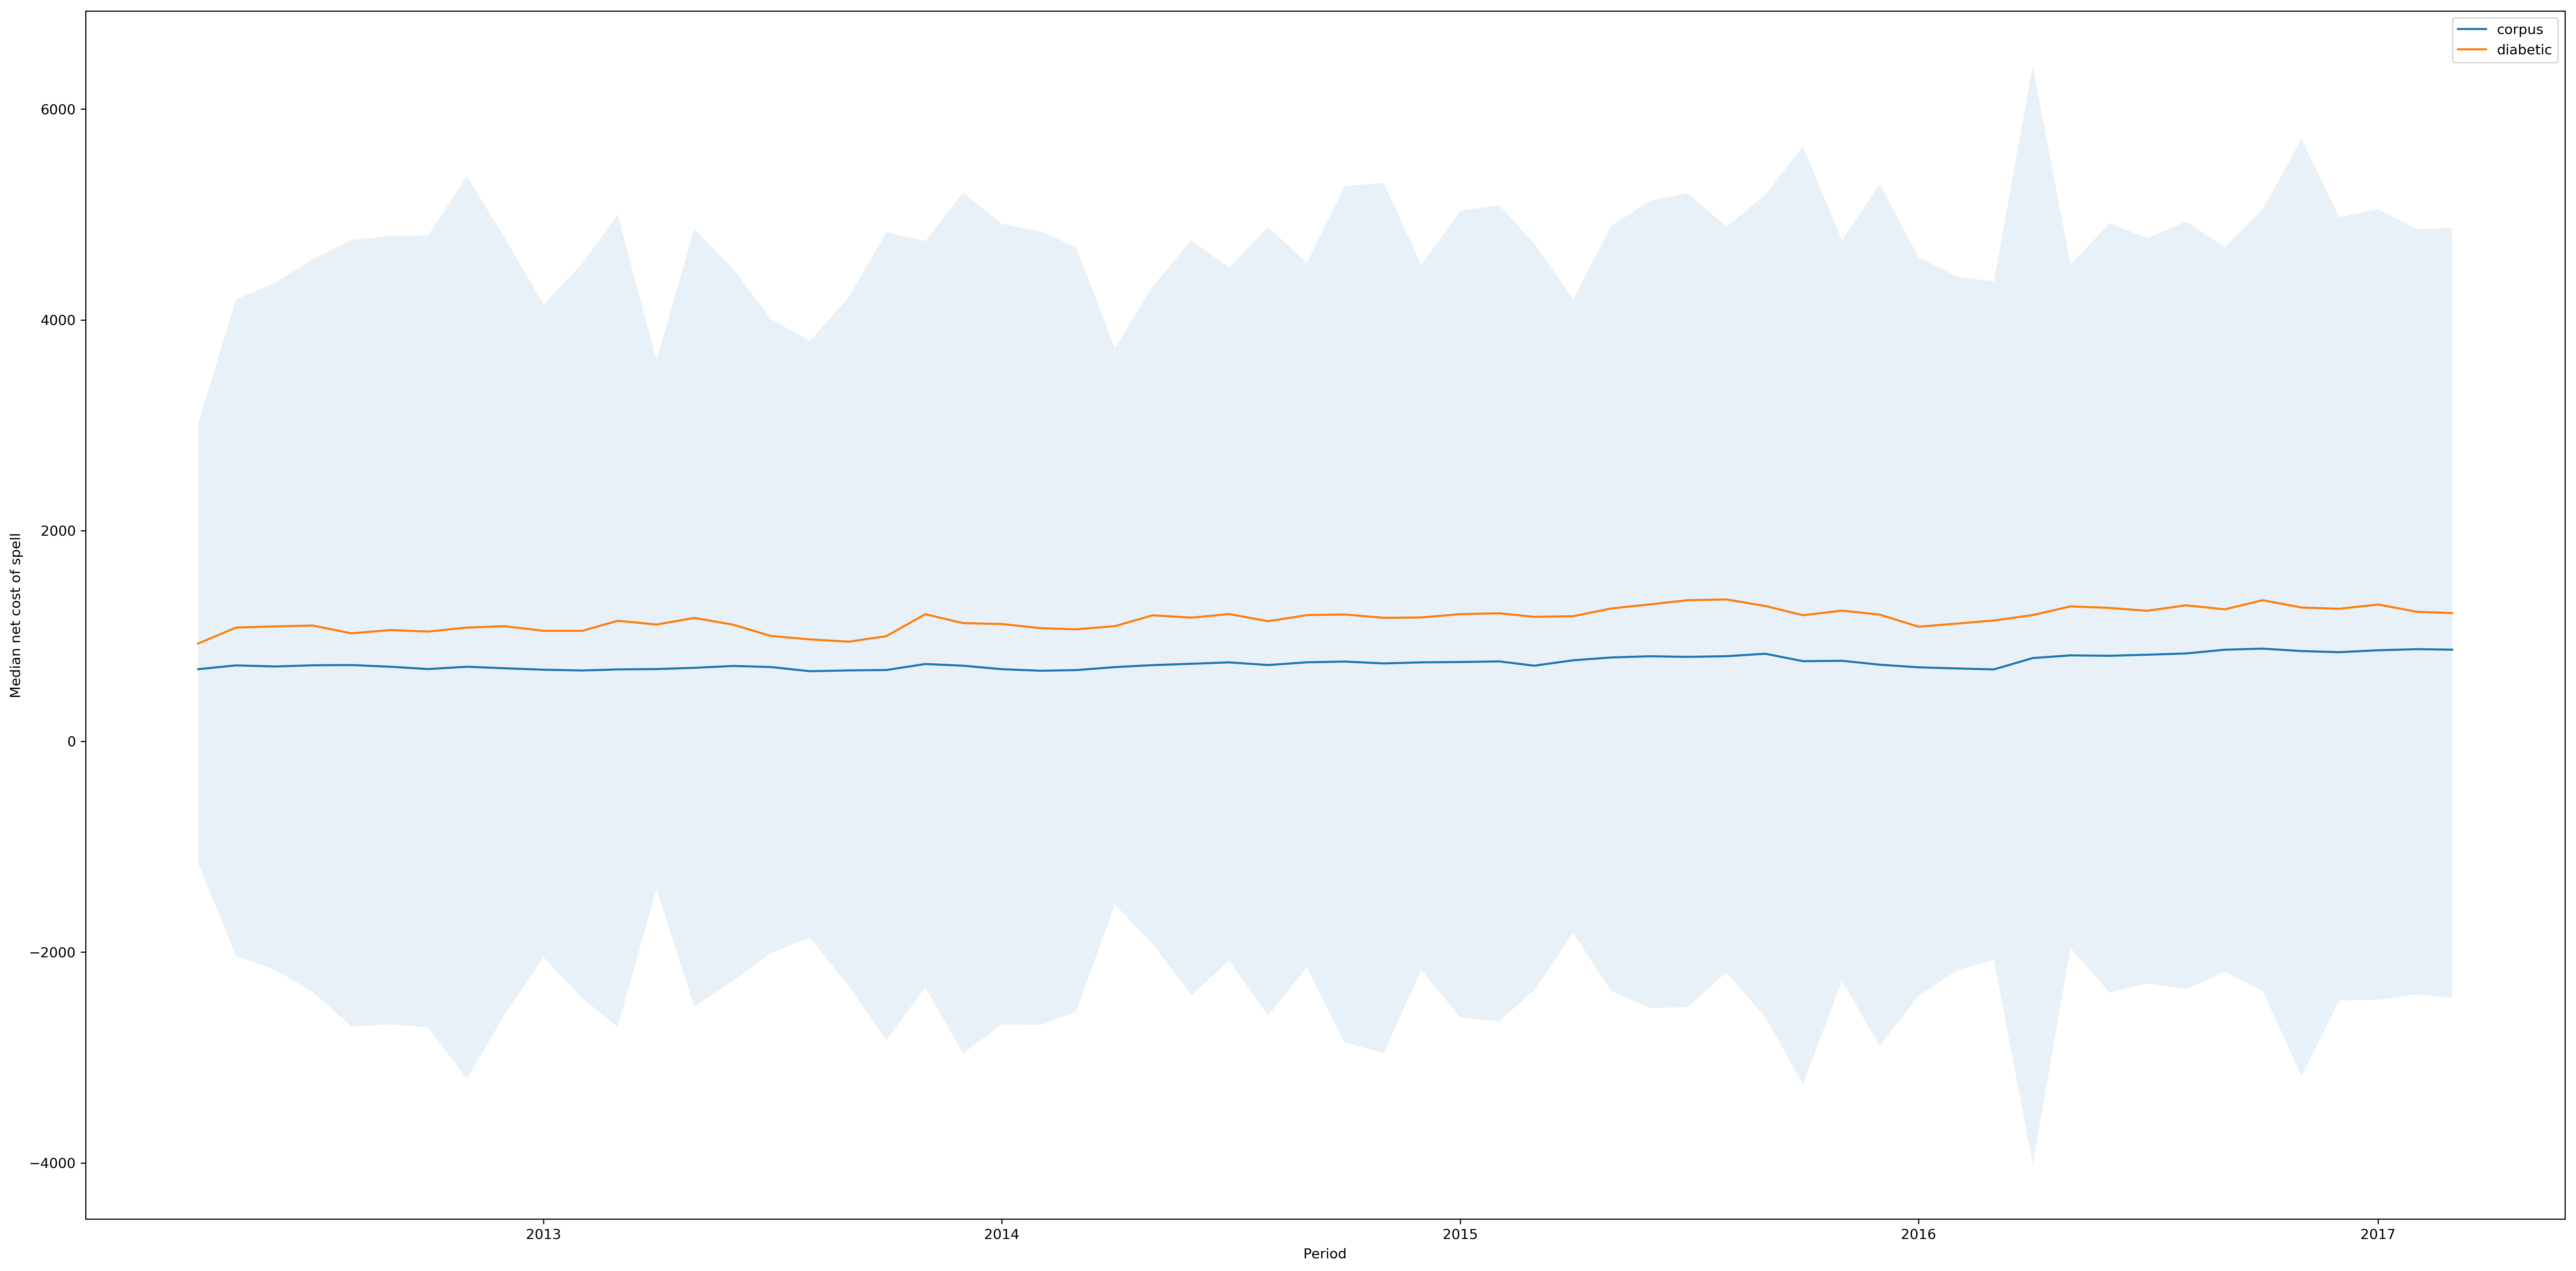

In [222]:
fig, ax = plt.subplots(1, figsize=(32, 16), dpi=300)

netcosts = (
    main.groupby(["PERIOD", "SPELL_ID"])["NetCost"]
    .sum()
    .reset_index()
    .groupby("PERIOD")["NetCost"]
)
median = netcosts.median()

ax.plot(median.index, median.values, label="corpus")

for name, data in zip(["diabetic"], [diabetic]):
    netcosts = (
        data.groupby(["PERIOD", "SPELL_ID"])["NetCost"]
        .sum()
        .reset_index()
        .groupby("PERIOD")["NetCost"]
    )
    median = netcosts.median()
    std = netcosts.std()

    ax.fill_between(
        median.index, median.values + std.values, median.values - std.values, alpha=0.1
    )

    ax.plot(median.index, median.values, label=name)

ax.set_ylabel("Median net cost of spell")
ax.set_xlabel("Period")
ax.legend()


In [195]:
cols = ["Age", "SEX", "Obese"] + [c for c in main.columns if c.endswith("_ChIdx")]
data = main[cols + ["NetCost"]]

scaler = prep.StandardScaler()
data[cols + ["NetCost"]] = scaler.fit_transform(data[cols + ["NetCost"]])


/Users/henrywilde/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/henrywilde/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [211]:
np.linspace(25, 50, 51)


array([25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. ,
       30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5,
       36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. ,
       41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 46.5,
       47. , 47.5, 48. , 48.5, 49. , 49.5, 50. ])

In [219]:
rdg = lm.RidgeCV(alphas=np.linspace(50.0, 100.0, 51))

rdg.fit(data[cols], data["NetCost"])


RidgeCV(alphas=array([ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100.]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [220]:
rdg.alpha_


100.0

In [221]:
X, y = data[cols].values, data["NetCost"]
params = np.append(rdg.intercept_, rdg.coef_)
y_pred = rdg.predict(X)

X_new = pd.DataFrame({"Constant": np.ones(len(X))}).join(pd.DataFrame(X))

MSE = metrics.mean_squared_error(y, y_pred)

# np.dot(X_new.T, X_new) is singular so cannot be inversed non-iteratively.
# This is likely due to high multicollinearity.

var = MSE * (np.linalg.pinv(np.dot(X_new.T, X_new)).diagonal())
std = np.sqrt(var)
t_values = params / std

p_values = [
    2 * (1 - scipy.stats.t.cdf(np.abs(t_val), (len(X_new) - 1))) for t_val in t_values
]


TypeError: can't multiply sequence by non-int of type 'str'

In [ ]:
results = pd.DataFrame(
    {
        "Variable": ["Intercept"] + cols,
        "Coefficient": params,
        "Std. Error": std,
        "t-Value": t_values,
        "p-Value": p_values,
    }
)

results


In [ ]:
metrics.explained_variance_score(y, y_pred), metrics.mean_squared_error(
    y, y_pred
), metrics.r2_score(y, y_pred)
